In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

In [2]:
if torch.cuda.is_available():
    print("Using cuda")
    torch.set_default_device('cuda:0')

Using cuda


In [5]:
dataset_folder = os.path.join("put_jetbot_dataset", "dataset")
print(os.listdir(dataset_folder))

['1652875851.3497071', '1652875851.3497071.csv', '1652875901.3107166', '1652875901.3107166.csv', '1652876013.741493', '1652876013.741493.csv', '1652876206.2541456', '1652876206.2541456.csv', '1652876485.8123376', '1652876485.8123376.csv', '1652959186.4507334', '1652959186.4507334.csv', '1652959347.972946', '1652959347.972946.csv', '1653042695.4914637', '1653042695.4914637.csv', '1653042775.5213027', '1653042775.5213027.csv', '1653043202.5073502', '1653043202.5073502.csv', '1653043345.3415065', '1653043345.3415065.csv', '1653043428.8546412', '1653043428.8546412.csv', '1653043549.5187616', '1653043549.5187616.csv']


In [41]:
X = []
y = []

for file in os.listdir(dataset_folder):
    if not file.endswith(".csv"):
        continue

    dataset_name = file[:-4]

    data = pd.read_csv(os.path.join(dataset_folder, str(file)), header=None)

    for _, row in data.iterrows():
        img_id, forward, left = row
        img_path = os.path.join(dataset_folder, dataset_name, f"{int(img_id):04d}.jpg")

        X.append(img_path)
        y.append([forward, left])

X = np.array(X)
y = np.array(y, dtype=np.float32)

X.shape, y.shape

((7584,), (7584, 2))

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=23, test_size=0.25)

In [8]:
class JetBotImageDataset(Dataset):
    def __init__(self, image_paths, image_ys, transform=None):
        self.image_paths = image_paths
        self.image_ys = image_ys
        self.transform = transform

        assert len(image_paths) == len(image_ys)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = read_image(self.image_paths[idx])
        label = self.image_ys[idx]
        if self.transform:
            image = self.transform(image)

        return image, label

In [43]:
transform = v2.Compose([
    v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.75, 1.25)),
    v2.ToDtype(torch.float32, scale=True)
])

In [44]:
train_dataset = JetBotImageDataset(X_train, y_train, transform)
test_dataset = JetBotImageDataset(X_test, y_test, transform)

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [46]:
train_features, train_labels = next(iter(test_dataloader))

In [15]:
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(20, 6))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

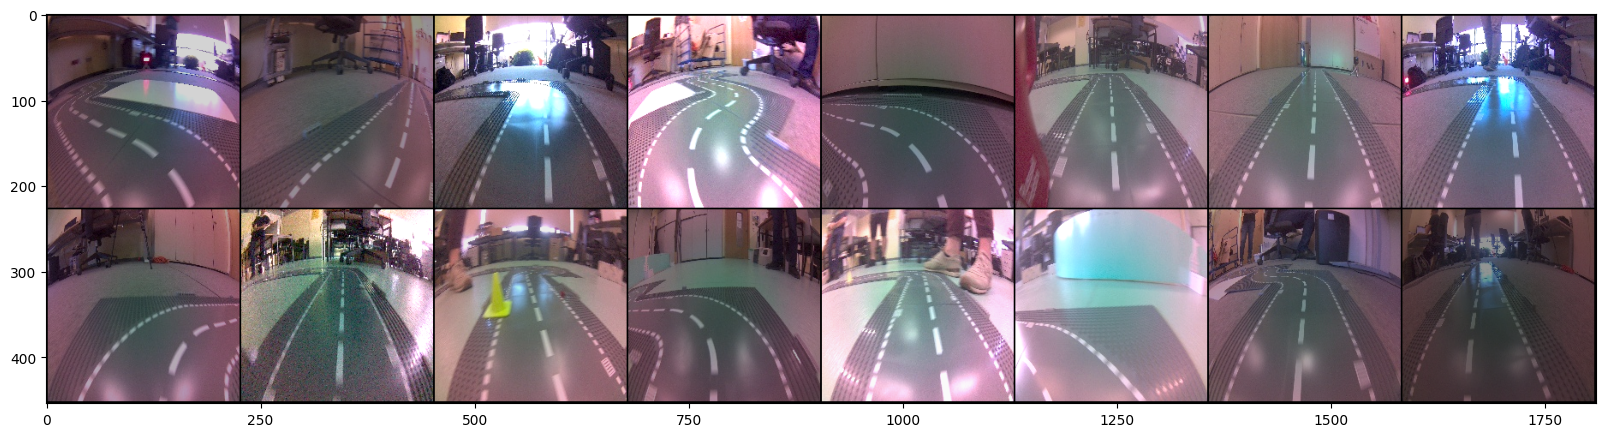

In [16]:
imshow(torchvision.utils.make_grid(train_features))

In [123]:
class SteeringCNN(nn.Module):
    def __init__(self):
        super(SteeringCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.forward_layers = nn.Sequential(
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

        self.left_layers = nn.Sequential(
            nn.Linear(25088, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        forward = self.forward_layers(x)
        left = self.left_layers(x)
        return torch.cat((forward, left), dim=1)

In [22]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [124]:
net = SteeringCNN()
net.to(device)

SteeringCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (forward_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (left_layers): Sequential(
    (0): Linear(in_features=25088, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Tanh()
  )
)

In [24]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [47]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = loss_fn(outputs, labels)
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

        if i % 50 == 49:
            last_loss = running_loss / 50
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.
            
    return last_loss

In [26]:
for epoch in range(3):
    print('EPOCH {}:'.format(epoch + 1))
    
    net.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    net.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
            

EPOCH 1:
  batch 50 loss: 0.23987781539559364
  batch 100 loss: 0.22342053152620792
  batch 150 loss: 0.2260404857993126
  batch 200 loss: 0.22850851133465766
  batch 250 loss: 0.22688287854194641
  batch 300 loss: 0.19180410385131835
  batch 350 loss: 0.2030270990729332
LOSS train 0.2030270990729332 valid 0.17425072193145752
EPOCH 2:
  batch 50 loss: 0.173470618724823
  batch 100 loss: 0.16049594908952713
  batch 150 loss: 0.15197893291711806
  batch 200 loss: 0.15080132842063904
  batch 250 loss: 0.15354799449443818
  batch 300 loss: 0.12952568486332894
  batch 350 loss: 0.1428314758837223
LOSS train 0.1428314758837223 valid 0.14050741493701935
EPOCH 3:
  batch 50 loss: 0.12943481728434564
  batch 100 loss: 0.12773530893027782
  batch 150 loss: 0.12760494075715542
  batch 200 loss: 0.11781481176614761
  batch 250 loss: 0.1239764541387558
  batch 300 loss: 0.10516777701675892
  batch 350 loss: 0.11848969034850597
LOSS train 0.11848969034850597 valid 0.11529006063938141


In [27]:
sum(p.numel() for p in net.parameters())

1606170

In [30]:
import torch.onnx

x = torch.randn(32, 3, 224, 224, requires_grad=True)

torch.onnx.export(net, x, 'test.onnx', export_params=True)

# Smaller model proposition

In [109]:
class SmallerCNN(nn.Module):
    def __init__(self):
        super(SmallerCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256*7*7, 64),  # Output: 256*7*7 input features
            nn.ReLU(),
            nn.Linear(64, 2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.fc_layers(x)
        return x

In [110]:
sm_net = SmallerCNN()
sm_net.to(device)

SmallerCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=12544, out_feature

In [111]:
sum(p.numel() for p in sm_net.parameters())

1195618

In [112]:
# training
loss_fn = nn.MSELoss()
optimizer = optim.Adam(sm_net.parameters(), lr=0.001)

for epoch in range(3):
    print('EPOCH {}:'.format(epoch + 1))
    
    sm_net.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    sm_net.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = sm_net(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

EPOCH 1:
  batch 50 loss: 0.10858374170958995
  batch 100 loss: 0.10976335220038891
  batch 150 loss: 0.10953295730054378
  batch 200 loss: 0.10659158378839492
  batch 250 loss: 0.10910900250077248
  batch 300 loss: 0.09492152474820614
  batch 350 loss: 0.1095011591911316
LOSS train 0.1095011591911316 valid 0.7263345122337341
EPOCH 2:
  batch 50 loss: 0.10583263576030731
  batch 100 loss: 0.10947944521903992
  batch 150 loss: 0.11132455140352249
  batch 200 loss: 0.10489091202616692
  batch 250 loss: 0.11210669949650764
  batch 300 loss: 0.0933709941804409
  batch 350 loss: 0.11118725433945656
LOSS train 0.11118725433945656 valid 0.7263189554214478
EPOCH 3:
  batch 50 loss: 0.10659004539251328
  batch 100 loss: 0.11303313873708248
  batch 150 loss: 0.10992321982979775
  batch 200 loss: 0.10403775349259377
  batch 250 loss: 0.10853337444365024
  batch 300 loss: 0.09452857986092568
  batch 350 loss: 0.10938659571111202
LOSS train 0.10938659571111202 valid 0.7263413667678833


In [113]:
# export as onnx with OPSET 11
x = torch.randn(32, 3, 224, 224, requires_grad=True)
torch.onnx.export(sm_net, x, 'smaller_cnn_1p2m.onnx', export_params=True, opset_version=11)

# Can we go even smaller?

In [119]:
class EvenSmallerCNN(nn.Module):
    def __init__(self):
        super(EvenSmallerCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                   
        )

        self.fc_layers_forward = nn.Sequential(
            nn.Linear(128*7*7, 32),  
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )
        self.fc_layers_left = nn.Sequential(
            nn.Linear(128*7*7, 32),  
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        forward = self.fc_layers_forward(x)
        left = self.fc_layers_left(x)
        return torch.cat((forward, left), dim=1)

In [120]:
model = EvenSmallerCNN()
print(sum(p.numel() for p in model.parameters()))

499922


In [121]:
# training
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(3):
    print('EPOCH {}:'.format(epoch + 1))
    
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    
    running_vloss = 0.0
    
    model.eval()
    
    with torch.no_grad():
        for i, vdata in enumerate(test_dataloader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

EPOCH 1:
  batch 50 loss: 0.10797961227595806
  batch 100 loss: 0.11040185399353504
  batch 150 loss: 0.1097271865606308
  batch 200 loss: 0.10439245812594891
  batch 250 loss: 0.10976241037249565
  batch 300 loss: 0.09445013292133808
  batch 350 loss: 0.10998289674520492
LOSS train 0.10998289674520492 valid 0.5890232920646667
EPOCH 2:
  batch 50 loss: 0.1058136486262083
  batch 100 loss: 0.11222981505095958
  batch 150 loss: 0.10801349770277739
  batch 200 loss: 0.10512653604149819
  batch 250 loss: 0.10908537097275257
  batch 300 loss: 0.09566036850214005
  batch 350 loss: 0.11067071236670017
LOSS train 0.11067071236670017 valid 0.5890181660652161
EPOCH 3:
  batch 50 loss: 0.10788981638848781
  batch 100 loss: 0.10884627394378185
  batch 150 loss: 0.10839810959994793
  batch 200 loss: 0.10428949002176523
  batch 250 loss: 0.11081165805459023
  batch 300 loss: 0.09874908044934273
  batch 350 loss: 0.1102319248020649
LOSS train 0.1102319248020649 valid 0.5890244841575623


In [122]:
# onnx export
x = torch.randn(32, 3, 224, 224, requires_grad=True)
torch.onnx.export(model, x, 'even_smaller_cnn_0p5m.onnx', export_params=True, opset_version=11)